In [ ]:
# installs
# pip install scikit-learn


In [ ]:
# imports - usual suspects
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# for distance and h-clustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform


# sklearn does have some functionality too, but mostly a wrapper to scipy
from sklearn.metrics import pairwise_distances 
from sklearn.preprocessing import StandardScaler

In [ ]:
# let's start basic
x = np.array([1,2])
y = np.array([3,4])
z = np.array([2,4])
a = np.stack([x,y,z])
a_df = pd.DataFrame(a)  # dataframe version
a                       # nd array

array([[1, 2],
       [3, 4],
       [2, 4]])

In [ ]:
# lets get the euclidean distance
d1 = pdist(a)

# prints out as pairs 
# 0/1, 0/2, 1/2
# https://stackoverflow.com/a/13079806/155406
d1

array([2.82842712, 2.23606798, 1.        ])

In [ ]:
# what is it
# technically its a condensed matrix of the upper triangle as 1d array
print(type(d1))
print(d1.shape)

<class 'numpy.ndarray'>
(3,)


In [ ]:
# but what we are mostly used to is the squareform
squareform(d1)

array([[0.        , 2.82842712, 2.23606798],
       [2.82842712, 0.        , 1.        ],
       [2.23606798, 1.        , 0.        ]])

In [ ]:
# NOTE: there are tools in sklearn, but some methods allow us to pass a compressed matrix
#       which gives us an analysts control over the input space


In [ ]:
# QUICK EXERCISE:
#                 calculate the cosine distance matrix
#                 Tricky: calculate the Manhattan distance 
#                       HINT: documentation is your friend

cd = pdist(a, metric="cosine")
print(squareform(cd))

md = pdist(a, metric="cityblock")
print(squareform(md))

[[0.00000000e+00 1.61300899e-02 2.22044605e-16]
 [1.61300899e-02 0.00000000e+00 1.61300899e-02]
 [2.22044605e-16 1.61300899e-02 0.00000000e+00]]
[[0. 4. 3.]
 [4. 0. 1.]
 [3. 1. 0.]]


In [ ]:
## there are other distance calcs, but I really dont see these come up that often in practical applications
## nothing stopping you from looping parameters to assess what works the best

In [ ]:
# we can also use sklearn to calc distances
pairwise_distances(a_df, metric="euclidean")

array([[0.        , 2.82842712, 2.23606798],
       [2.82842712, 0.        , 1.        ],
       [2.23606798, 1.        , 0.        ]])

In [ ]:
# QUICK NOTE:
#             some implementations may be faster in sklearn, note the docs

?pairwise_distances

In [ ]:
# let's start to code up a simple example



In [ ]:
# auth into GCP Big Query
# COLAB Only
from google.colab import auth
auth.authenticate_user()


In [ ]:
# get the data
SQL = "SELECT * from `questrom.datasets.mtcars`"
YOUR_BILLING_PROJECT = "questrom"

cars = pd.read_gbq(SQL, YOUR_BILLING_PROJECT)

In [ ]:
# what do we have?
cars.shape

(32, 12)

In [ ]:
# the first few rows
cars.head(3)

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,model
0,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2,Merc 240D
1,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2,Merc 230
2,21.5,4,120.1,97,3.70,2.465,20.01,1,0,3,1,Toyota Corona


In [ ]:
# EXERCISE:
#         1) use the model column as the row index 
#         2) with the model column as index, we can now remove it
#         3) explore the data
#   Keep in mind that our goal is to use distance for clustering!
#   Does anything stand out?

In [ ]:
# lets drop the model column and use it as the index
cars.index = cars.model
cars.drop(columns="model", inplace=True)

In [ ]:
# confirm we have what we need
cars.head(3)

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
model,,,,,,,,,,,
Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2
Toyota Corona,21.5,4,120.1,97,3.70,2.465,20.01,1,0,3,1


In [ ]:
# ok, let's summarise the info
cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, Merc 240D to Maserati Bora
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mpg     32 non-null     float64
 1   cyl     32 non-null     int64  
 2   disp    32 non-null     float64
 3   hp      32 non-null     int64  
 4   drat    32 non-null     float64
 5   wt      32 non-null     float64
 6   qsec    32 non-null     float64
 7   vs      32 non-null     int64  
 8   am      32 non-null     int64  
 9   gear    32 non-null     int64  
 10  carb    32 non-null     int64  
dtypes: float64(5), int64(6)
memory usage: 3.0+ KB


In [ ]:
# no missing values is great, finally the summaries
cars.describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,32.0,20.090625,6.026948,10.400,15.42500,19.200,22.80,33.900
cyl,32.0,6.187500,1.785922,4.000,4.00000,6.000,8.00,8.000
disp,32.0,230.721875,123.938694,71.100,120.82500,196.300,326.00,472.000
hp,32.0,146.687500,68.562868,52.000,96.50000,123.000,180.00,335.000
drat,32.0,3.596562,0.534679,2.760,3.08000,3.695,3.92,4.930
wt,32.0,3.217250,0.978457,1.513,2.58125,3.325,3.61,5.424
qsec,32.0,17.848750,1.786943,14.500,16.89250,17.710,18.90,22.900
vs,32.0,0.437500,0.504016,0.000,0.00000,0.000,1.00,1.000
am,32.0,0.406250,0.498991,0.000,0.00000,0.000,1.00,1.000
gear,32.0,3.687500,0.737804,3.000,3.00000,4.000,4.00,5.000


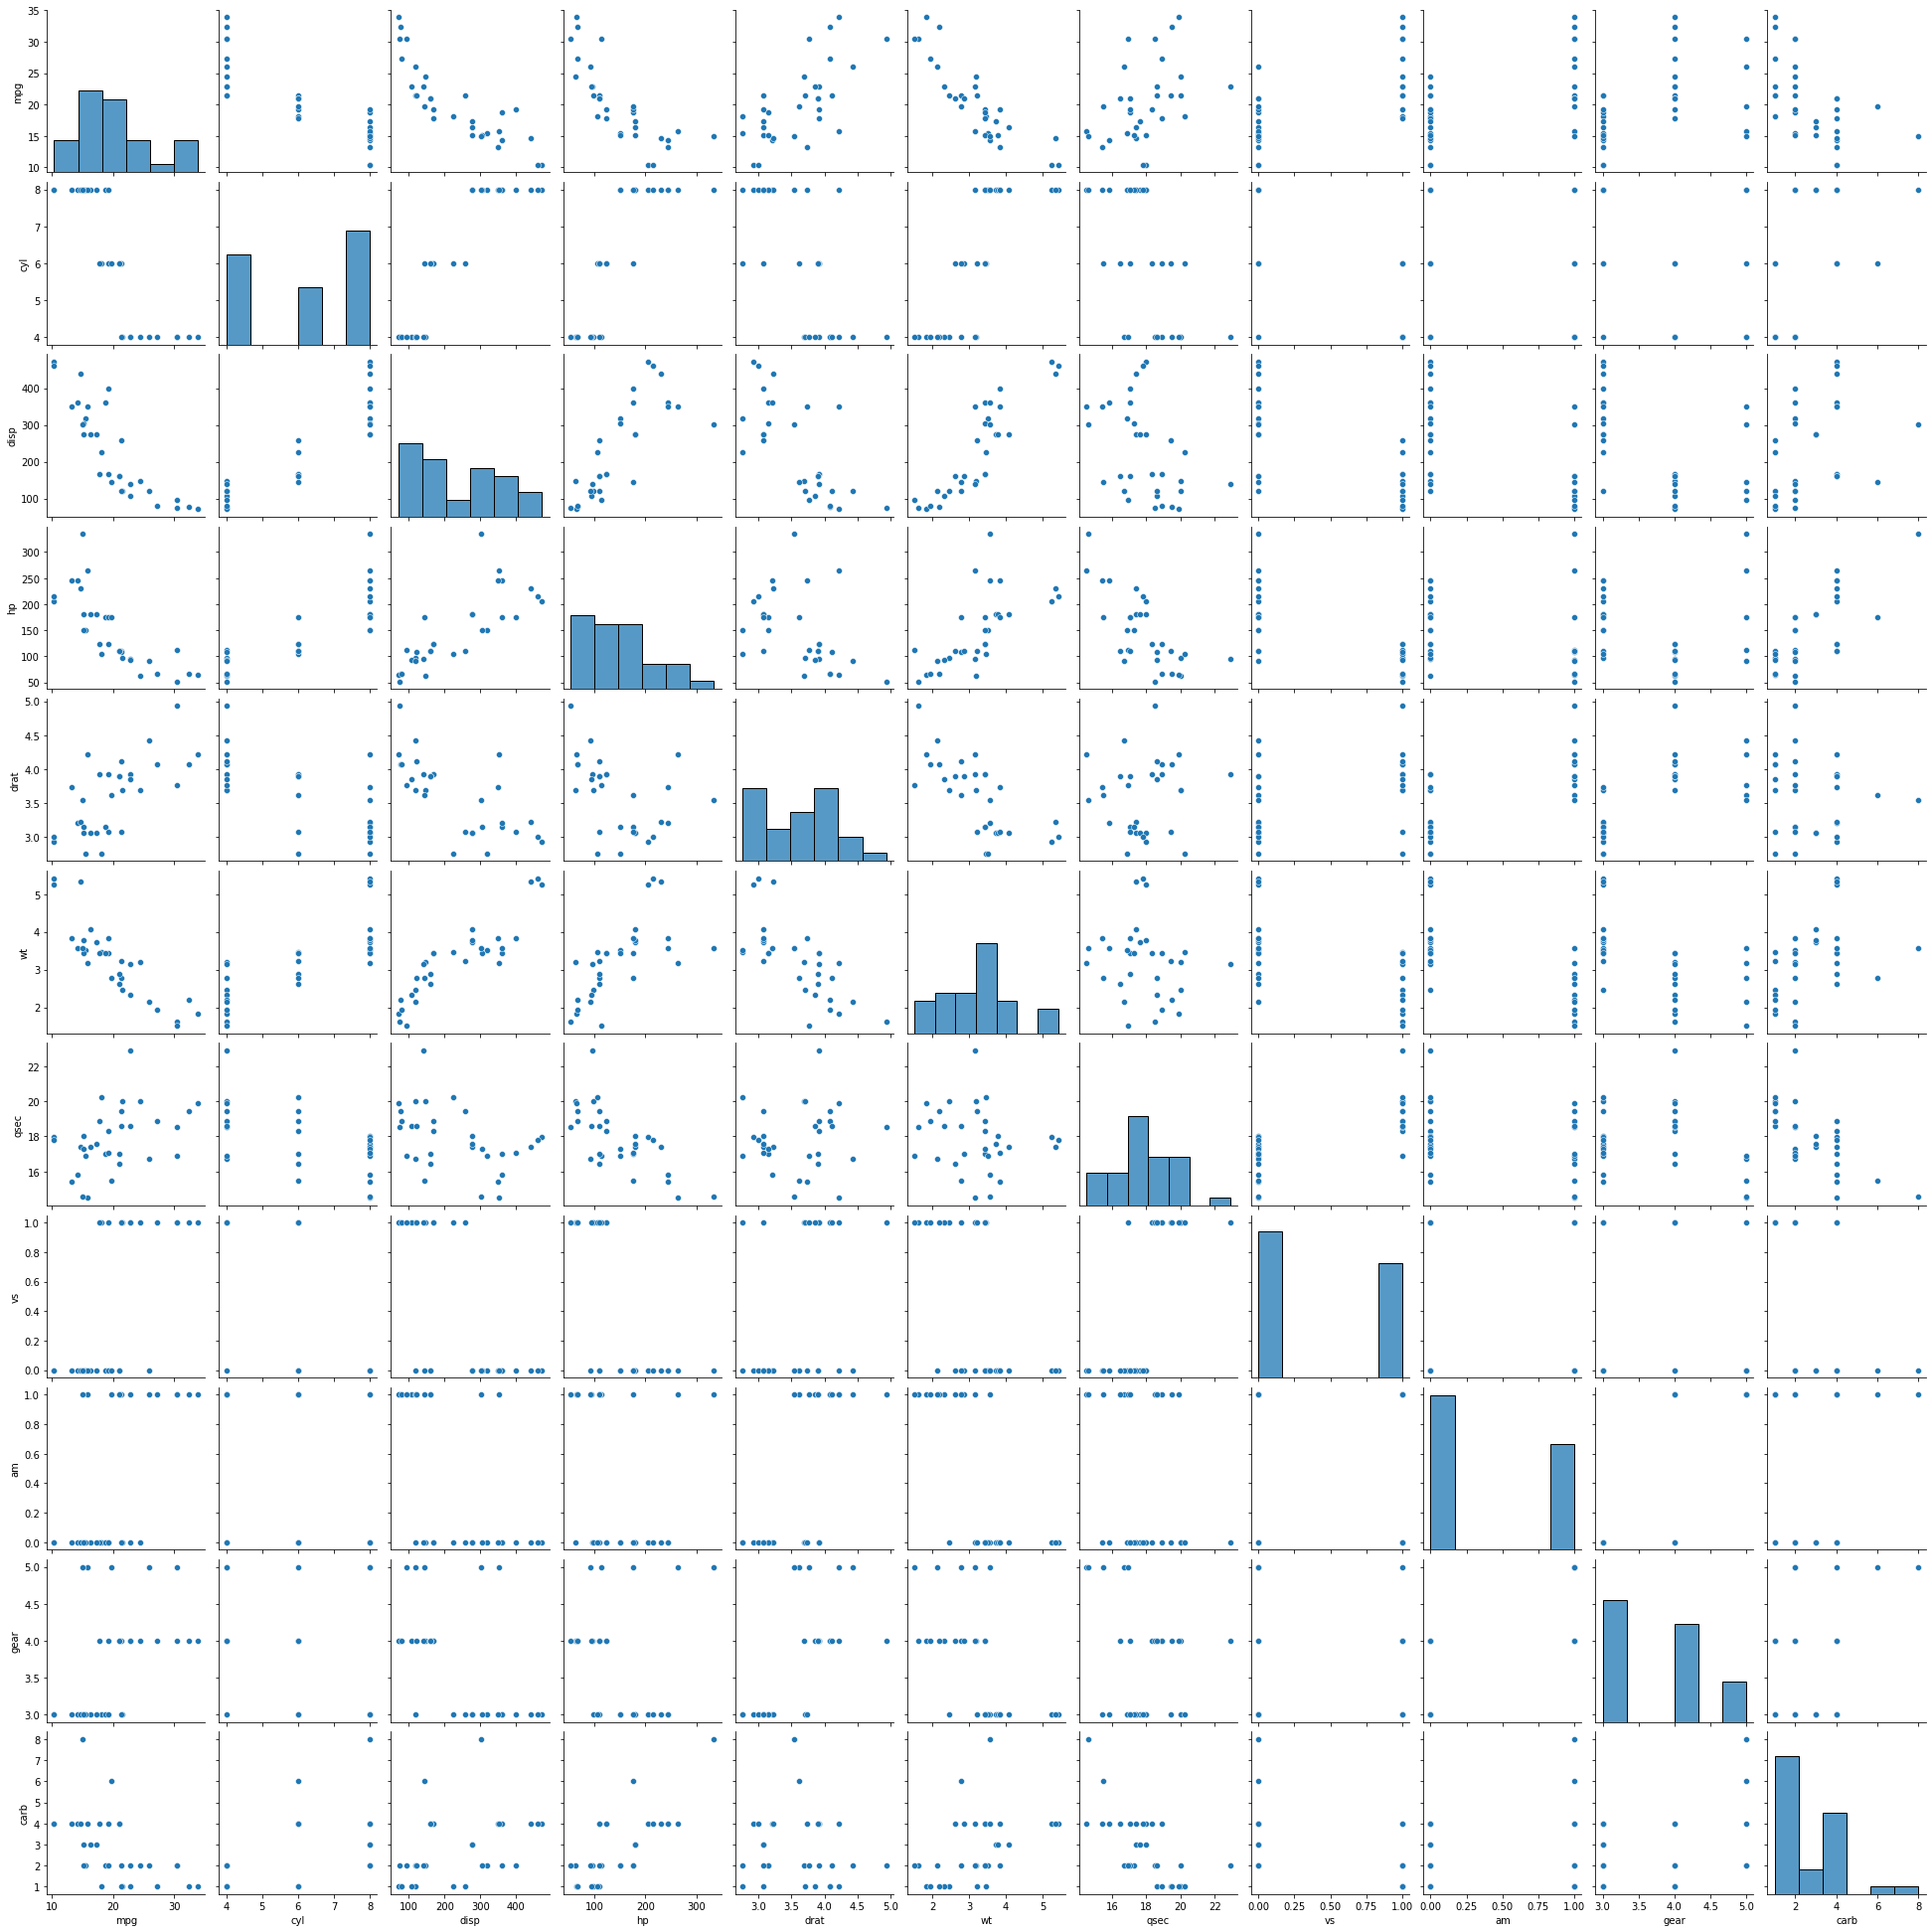

In [ ]:
# optional viz, but takes some time
sns.pairplot(cars)


In [ ]:
# keep just the continous variables
cars2 = pd.concat((cars.loc[:, "mpg"], cars.loc[:, "disp":"qsec"]), axis=1)

In [ ]:
# confirm we have what we need
cars2.head(3)

,mpg,disp,hp,drat,wt,qsec
model,,,,,,
Merc 240D,24.4,146.7,62,3.69,3.190,20.00
Merc 230,22.8,140.8,95,3.92,3.150,22.90
Toyota Corona,21.5,120.1,97,3.70,2.465,20.01


In [ ]:
cars.columns

Index(['mpg', 'cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am', 'gear',
       'carb'],
      dtype='object')

In [ ]:
# eventually we want to run the distance matrix through linkage
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html


In [ ]:
# use scipy for distance matrix
cdist = pdist(cars2.values)

In [ ]:
## Why?  We have more control, as we could always build our distance matrix to our needs
##       Above is just the mechanics of getting this done

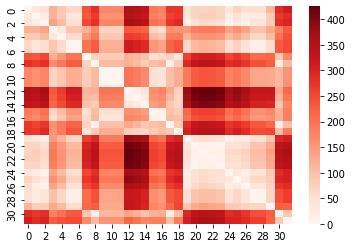

In [ ]:
# visualize the matrix with seaborn
sns.heatmap(squareform(cdist), cmap="Reds")

In [ ]:
# Thought exercise:  Why might this help us think about the # of clusters

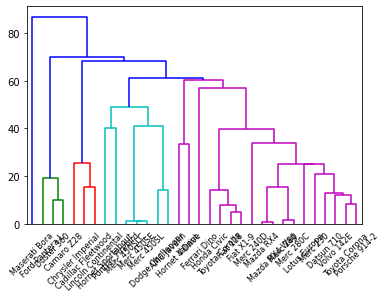

In [ ]:
# lets perform our first hclust!
hc1 = linkage(cdist)

# now visualize the dendrogram
dendrogram(hc1, labels=cars.index)
plt.show()

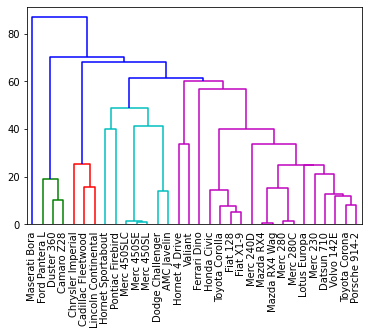

In [ ]:
# the labels for the cluster - cleaner
dendrogram(hc1,
           labels = cars.index,
           leaf_rotation=90,
           leaf_font_size=10)
plt.show()


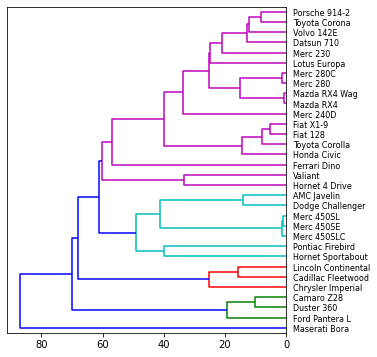

In [ ]:
# and the orientation/size
plt.figure(figsize=(5,6))
dendrogram(hc1,
           labels = cars.index,
           orientation = "left")
plt.show()

In [ ]:
# once we have seen the plots, we can start to think about cutting this up
# to define clusters - we use fcluster
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html

In [ ]:
# we can slice up our clusters a few ways
# first, how many clusters (max)
fcluster(hc1, 2, criterion="maxclust")

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2], dtype=int32)

In [ ]:
# we can also define by the distance
fcluster(hc1, 80, criterion="distance")

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2], dtype=int32)

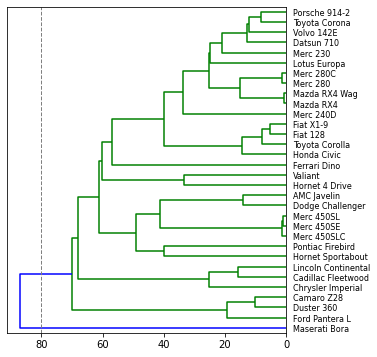

In [ ]:
# want to visualize how you defined the cluster?
DIST = 80
plt.figure(figsize=(5,6))
dendrogram(hc1, 
           labels = cars.index,
           orientation = "left", 
           color_threshold = DIST)
plt.axvline(x=DIST, c='grey', lw=1, linestyle='dashed')
plt.show()

In [ ]:
# YOUR TURN:
#           Use cosine distance
#           generate the linkage array
#           plot the dendrogram
#           assign the cluster labels back onto the ORIGINAL dataframe

# the distance
cdist_cosine = pdist(cars2, metric="cosine")

# the linkage
hc2 = linkage(cdist_cosine)



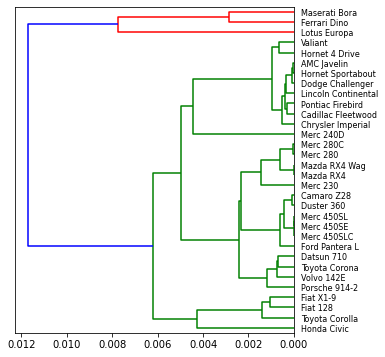

In [ ]:
# plot it
plt.figure(figsize=(5,6))
dendrogram(hc2,
           labels = cars.index,
           orientation = "left")
plt.show()

In [ ]:
# I see 4 clusters - put on the ORIGINAL dataframe from GCP
hc2_labels = fcluster(hc2, 4, "maxclust")
cars['cosine_labels'] = hc2_labels
cars.head(3)

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,cosine_labels
model,,,,,,,,,,,,
Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2,2
Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2,2
Toyota Corona,21.5,4,120.1,97,3.70,2.465,20.01,1,0,3,1,2


In [ ]:
# now that we have labels assigned, we can profile
cars.groupby("cosine_labels").mean()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
cosine_labels,,,,,,,,,,,
1,31.000,4.00,76.125,62.25,4.3275,1.89625,19.1975,1.00,1.00,4.00,1.25
2,18.152,6.56,261.500,152.88,3.4740,3.50056,17.8948,0.36,0.24,3.48,2.76
3,17.350,7.00,223.000,255.00,3.5800,3.17000,15.0500,0.00,1.00,5.00,7.00
4,30.400,4.00,95.100,113.00,3.7700,1.51300,16.9000,1.00,1.00,5.00,2.00


In [ ]:
# data dictionary for profiling above
# https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/mtcars.html

In [ ]:
# DISCUSSION:
#            This is a simple dataset, but why is profiling important for us as analyts?
#            Applications of this approach?

In [ ]:
# ok, 3 more things to consider
# scaling the data to give all features equal importance
# viz different approaches instead of 1x1
# more "advanced" ways to think about distance to help us inform cluster selection


In [ ]:
# lets go back to our cars2 dataset (the one with just "continous")
cars2.head(3)

,mpg,disp,hp,drat,wt,qsec
model,,,,,,
Merc 240D,24.4,146.7,62,3.69,3.190,20.00
Merc 230,22.8,140.8,95,3.92,3.150,22.90
Toyota Corona,21.5,120.1,97,3.70,2.465,20.01


In [ ]:
# scaling variables allows each to have equal importance
# since they are now on the same unit scale
sc = StandardScaler()
cars_scaled = sc.fit_transform(cars2)

In [ ]:
# what do we have
type(cars_scaled)

numpy.ndarray

In [ ]:
# make it a dataframe
cars_scaled = pd.DataFrame(cars_scaled, columns=cars2.columns, index=cars2.index)
cars_scaled.head(3)

,mpg,disp,hp,drat,wt,qsec
model,,,,,,
Merc 240D,0.726459,-0.688779,-1.254944,0.177551,-0.028296,1.223135
Merc 230,0.456737,-0.737144,-0.765933,0.614599,-0.069830,2.871986
Toyota Corona,0.237587,-0.906835,-0.736296,0.196553,-0.781114,1.228820


In [ ]:
# confirm scaled
cars_scaled.describe()


,mpg,disp,hp,drat,wt,qsec
count,3.200000e+01,3.200000e+01,3.200000e+01,3.200000e+01,3.200000e+01,3.200000e+01
mean,-5.169476e-16,4.163336e-17,2.775558e-17,-2.693158e-16,1.786765e-16,5.759282e-16
std,1.016001e+00,1.016001e+00,1.016001e+00,1.016001e+00,1.016001e+00,1.016001e+00
min,-1.633610e+00,-1.308518e+00,-1.403130e+00,-1.589643e+00,-1.769642e+00,-1.903996e+00
25%,-7.865141e-01,-9.008917e-01,-7.437050e-01,-9.815764e-01,-6.604034e-01,-5.436944e-01
50%,-1.501383e-01,-2.821771e-01,-3.510140e-01,1.870518e-01,1.118844e-01,-7.888899e-02
75%,4.567366e-01,7.810529e-01,4.936423e-01,6.145986e-01,4.078199e-01,5.977084e-01
max,2.327934e+00,1.977904e+00,2.790515e+00,2.533809e+00,2.291423e+00,2.871986e+00


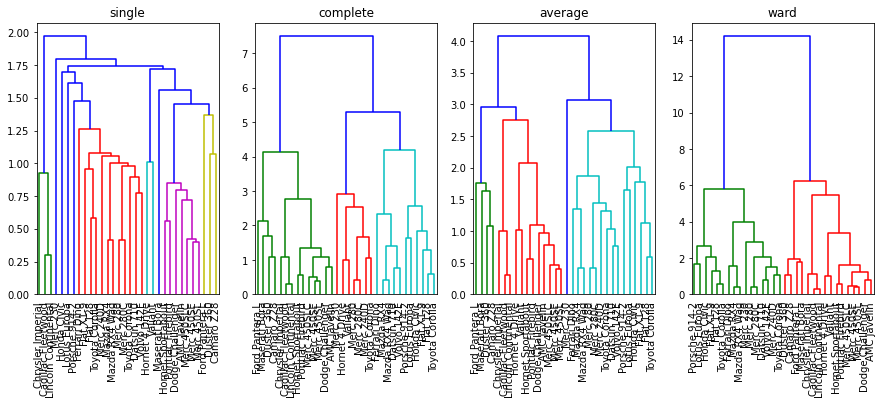

In [ ]:
METHODS = ['single', 'complete', 'average', 'ward']
plt.figure(figsize=(15,5))


# loop and build our plot
for i, m in enumerate(METHODS):
  plt.subplot(1, 4, i+1)
  plt.title(m)
  dendrogram(linkage(cars_scaled.values, method=m),
             labels = cars_scaled.index,
             leaf_rotation=90,
             leaf_font_size=10)
  
plt.show()


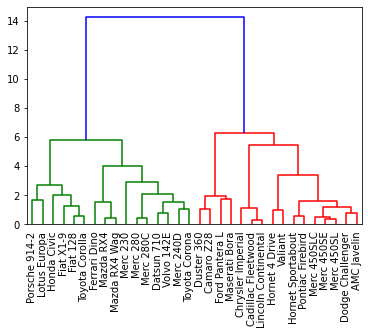

In [ ]:
# I am going to choose ward, choose whatever you like below
wlink = linkage(cars_scaled.values, method="ward")
dendrogram(wlink,
          labels = cars_scaled.index,
          leaf_rotation=90,
          leaf_font_size=10)

plt.show()

In [ ]:
# lets look at the distance added at each step
# docs = 4th paragraph for output
type(wlink)

numpy.ndarray

In [ ]:
# length
len(wlink)

31

In [ ]:
wlink

array([[12.        , 13.        ,  0.30041369,  2.        ],
       [ 9.        , 10.        ,  0.40073781,  2.        ],
       [27.        , 28.        ,  0.41411178,  2.        ],
       [ 5.        ,  6.        ,  0.41482144,  2.        ],
       [11.        , 33.        ,  0.481265  ,  3.        ],
       [ 7.        , 18.        ,  0.55629437,  2.        ],
       [20.        , 22.        ,  0.58500495,  2.        ],
       [19.        , 26.        ,  0.77171406,  2.        ],
       [15.        , 16.        ,  0.79529449,  2.        ],
       [ 3.        ,  4.        ,  1.00959706,  2.        ],
       [ 0.        ,  2.        ,  1.05956084,  2.        ],
       [ 8.        , 17.        ,  1.07232025,  2.        ],
       [14.        , 32.        ,  1.14707191,  3.        ],
       [36.        , 40.        ,  1.22123013,  5.        ],
       [23.        , 38.        ,  1.2638346 ,  3.        ],
       [39.        , 42.        ,  1.52050559,  4.        ],
       [29.        , 34.

In [ ]:
# lets look at the growth in distance added
added_dist = wlink[:, 2]
added_dist

array([ 0.30041369,  0.40073781,  0.41411178,  0.41482144,  0.481265  ,
        0.55629437,  0.58500495,  0.77171406,  0.79529449,  1.00959706,
        1.05956084,  1.07232025,  1.14707191,  1.22123013,  1.2638346 ,
        1.52050559,  1.53692464,  1.60649865,  1.64584233,  1.77158514,
        1.94064751,  2.05116222,  2.07699711,  2.67683871,  2.89349805,
        3.39614912,  4.00533606,  5.45591306,  5.78963832,  6.26218442,
       14.23349056])

In [ ]:
# calculate the diff at each join
penalty = np.diff(added_dist)
penalty[-5:]

array([0.60918694, 1.450577  , 0.33372525, 0.4725461 , 7.97130614])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


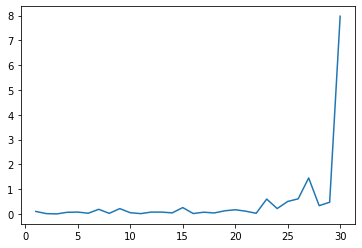

In [ ]:
# elbow method - what clustering step starts to show signs of explosion in distance
# remember, we lost one via the diff
sns.lineplot(range(1, len(penalty)+1), penalty)

In [ ]:
# we can re-inspect
wlink[25:]

array([[41.        , 49.        ,  3.39614912,  9.        ],
       [48.        , 56.        ,  4.00533606, 10.        ],
       [44.        , 57.        ,  5.45591306, 12.        ],
       [55.        , 58.        ,  5.78963832, 16.        ],
       [52.        , 59.        ,  6.26218442, 16.        ],
       [60.        , 61.        , 14.23349056, 32.        ]])

In [ ]:
# set the clusters based on max dist
labs2 = fcluster(wlink, 5.5, "distance")

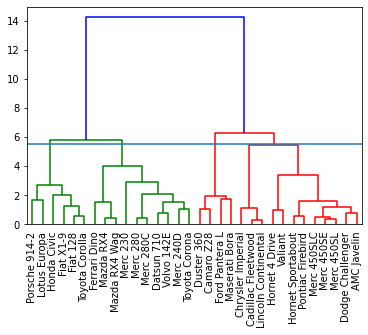

In [ ]:
dendrogram(wlink,
          labels = cars_scaled.index,
          leaf_rotation=90,
          leaf_font_size=10)
plt.axhline(y=5.5)

plt.show()

In [ ]:
# ensure intuition aligns with clusters
labs2

array([2, 2, 2, 4, 4, 2, 2, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 2, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 3, 3], dtype=int32)